## Importamos las librerías de openai y tavily para comprobar su funcionamiento

In [3]:
from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from dotenv import load_dotenv
import os

load_dotenv()

openai_api_key = os.getenv("OPENAI_API_KEY")
tavily_api_key = os.getenv("TAVILY_API_KEY")

llm = ChatOpenAI(model='gpt-4o-mini', temperature=0.3)
search_tool = TavilySearchResults(max_results=5)

print(llm.invoke('Cual es la capital de España?'))
print(search_tool.invoke('Cual es la capital de venezuela?'))

content='La capital de España es Madrid.' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 8, 'prompt_tokens': 15, 'total_tokens': 23, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_44added55e', 'id': 'chatcmpl-BMGgE3RQGmEq2DQHPXIjfxfdaiAyt', 'finish_reason': 'stop', 'logprobs': None} id='run-cec2366e-0096-4232-8146-36f7d900f2f4-0' usage_metadata={'input_tokens': 15, 'output_tokens': 8, 'total_tokens': 23, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}
[{'title': '[FREE] ¿Cuál es la capital de Venezuela? A. Valencia B. Maracaibo ...', 'url': 'https://brainly.com/question/58412178?source=next+question', 'content': 'La capital de Venezuela es Caracas, que es el cen

### Genial, nuestro llm funciona perfecto y la herramienta de busquedas también, ahora manejemos la arquitectura de nuestro agente

In [4]:
from langchain.memory import ConversationBufferMemory
session_memories = {}

def get_memory_for_session(session_id: str) -> ConversationBufferMemory:
    """Obtiene o crea una memoria específica para una sesión."""
    if session_id not in session_memories:
        session_memories[session_id] = ConversationBufferMemory(
            return_messages=True,
            memory_key="chat_history"
        )
    return session_memories[session_id]

## Creamos una funcion para manejar los session id y que nuestro agente tenga MEMORIA

In [6]:
from langchain_community.utilities import SQLDatabase
from langchain_community.tools.sql_database.tool import QuerySQLDatabaseTool
from langchain import hub
from typing import Literal
from typing_extensions import TypedDict
from typing import Annotated
from langgraph.graph import MessagesState, END,START
from langgraph.types import Command
from langchain_core.messages import HumanMessage
from langgraph.graph import Graph, StateGraph
from langgraph.prebuilt import create_react_agent


### Importamos todas las clases que usaremos para conectar nuestro agente especializado a bases de datos relacionales sql y elementos para generar el grafo con un manejo de estado óptimo y preciso

In [ ]:

members=["researcher", "sql_agent"]
options=members+['FINISH']

system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    f" following workers: {members}. Given the following user request,"
    " choose the most appropriate worker to handle it."
    " The researcher handles general knowledge questions."
    " The sql_agent handles database queries about sales, customers, and business data."
    " When the conversation is complete, respond with FINISH."
    " Consider the context of previous interactions when making your decision."
)

class State(MessagesState):
    next: str
    session_id: str = "default"
    context: dict = {}  # Almacenamiento por sesión
    sql_history: list = []  # Historial de seguimiento para sqls
    last_agent: str = ""  # Pasamos como estado el ultimo agente que ha respondido

class Router(TypedDict):
    """Trabajador a enrutar al siguiente. Si no se necesitan trabajadores, enrutar a FINISH."""

    next: Literal["researcher", "sql_agent", "FINISH"]



def supervisor_node(state: State) -> Command[Literal["researcher", "sql_agent", "__end__"]]:
    session_id = state["session_id"]
    memory=get_memory_for_session(session_id)
    messages = [
        {"role": "system", "content": system_prompt},
    ] + state["messages"]
    
 # Recuperar historial de memoria específico de la sesión
    chat_history = memory.load_memory_variables({}).get("chat_history", [])
    if chat_history:
        messages[0]["content"] += f"\nChat History: {chat_history}"

    if state["sql_history"]:
        sql_context = "\nPrevious SQL interactions: " + "; ".join(state["sql_history"][-3:])  # Ultimos 3 SQLs
        messages[0]["content"] += sql_context

    response = llm.with_structured_output(Router).invoke(messages)
    goto = response["next"]

    if goto != END:
        last_message = state["messages"][-1].content if state["messages"] else ""
        memory.save_context({"input": last_message}, {"output": goto})
        state["last_agent"] = goto

    if goto == "FINISH":
        goto = END

    return Command(
        goto=goto,
        update={
            "next": goto,
            "last_agent": state["last_agent"]
        }
    )


### Ya con esto definimos perfectamente el estado principal de nuestro agente y creamos de manera adecuada a nuestro agente orquestador. Ahora vamos a definir los miembros definidos en las listas previamente

In [8]:
research_agent = create_react_agent(
    model=llm,
    tools=[search_tool],
    prompt="Eres un agente experto en la búsqueda de información para responder preguntas usando siempre fuentes fiables, razonando de manera inteligente sobre tu respuesta."
)

def research_node(state: State) -> Command[Literal["supervisor"]]:
    """Research node that processes general knowledge queries."""
    session_id = state["session_id"]
    memory=get_memory_for_session(session_id)
    question = state["messages"][-1].content
    
    chat_history = memory.load_memory_variables({}).get("chat_history", [])
    if chat_history:
        enriched_query = f"Given this context: {chat_history}\nAnswer this question: {question}"
    else:
        enriched_query = question

    result = research_agent.invoke({
        "messages": [HumanMessage(content=enriched_query)]
    })

    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="researcher")
            ]
        },
        goto="supervisor"
    )


## Tenemos ya nuestro agente de busqueda definido con Tavily!! Ahora vamos con lo complejo, nuestro agente de sql.

In [9]:
db = SQLDatabase.from_uri("sqlite:///Chinook.db")## Definimos nuestra base de datos


query_prompt_template = hub.pull("langchain-ai/sql-query-system-prompt") ##Usamos el modulo hub para importar un prompt de SQL predefinido


class QueryOutput(TypedDict):
    """Generated SQL query."""
    query: Annotated[str, ..., "Syntactically valid SQL query."]  ##Creamos la clase para que el nodo cree una setencia sql valida y no texto. 
def sql_write_query(question: str) -> str:
    """Generate SQL query to fetch information."""
    prompt = query_prompt_template.invoke(
        {
            "dialect": db.dialect,
            "top_k": 10,
            "table_info": db.get_table_info(),
            "input": question
        }
    )
    structured_llm = llm.with_structured_output(QueryOutput)
    result = structured_llm.invoke(prompt)
    return result["query"]

def sql_execute_query(query: str) -> str:
    """Execute SQL query."""
    execute_query_tool = QuerySQLDatabaseTool(db=db)
    return execute_query_tool.invoke(query)

def sql_generate_answer(question: str, query: str, result: str) -> str:
    """Answer question using retrieved information as context."""
    prompt = (
        "Given the following user question, corresponding SQL query, "
        "and SQL result, answer the user question.\n\n"
        f'Question: {question}\n'
        f'SQL Query: {query}\n'
        f'SQL Result: {result}'
    )
    response = llm.invoke(prompt)
    return response.content

def sql_agent_node(state: State) -> Command[Literal["supervisor"]]:
    """SQL Agent node that processes database queries."""
    
    session_id = state["session_id"]
    memory = get_memory_for_session(session_id)
   
    last_message = state["messages"][-1]
    question = last_message.content
    
    # SQL pipeline
    query = sql_write_query(question)
    result = sql_execute_query(query)
    answer = sql_generate_answer(question, query, result)
    
 
    state["sql_history"].append(f"Q: {question} | SQL: {query}")
    if len(state["sql_history"]) > 10:  # Keep last 10 queries
        state["sql_history"] = state["sql_history"][-10:]
    
   
    memory.save_context({"input": question}, {"output": answer})

    return Command(
        update={
            "messages": [
                HumanMessage(content=answer, name="sql_agent")
            ],
            "sql_history": state["sql_history"]
        },
        goto="supervisor"
    )


c:\Users\Abraham Pérez\OneDrive\Desktop\Trabajo\panomada\repositorio_canal\agent_edu\Lib\site-packages\langsmith\client.py:278: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


## YA TENEMOS LOS AGENTES LISTOS!! Ahora solo queda procesar la información de los mensajes y definir nuestro grafo

In [10]:
workflow = StateGraph(State)
workflow.add_node("supervisor", supervisor_node)
workflow.add_edge(START,"supervisor")
workflow.add_node("researcher", research_node)
workflow.add_node("sql_agent", sql_agent_node)
#workflow.add_edge("supervisor", "researcher")
##workflow.add_edge("supervisor", "sql_agent")
##workflow.add_edge("researcher", "supervisor")
##workflow.add_edge("sql_agent", "supervisor")
##workflow.add_edge("supervisor", END)
#workflow.set_entry_point("supervisor")
graph = workflow.compile()

## Comentamos algunas aristas debido a que al usar "command" no es necesario definirlas de manera explícita, sin embargo ahí tienen un ejemplo de como se verían (ignorando que en todo caso usaríamos conditional edge para que el grafo defina su flujo de manera autonoma)

In [11]:
def process_message(message: str, session_id: str = "default"):
    """Process a message through the multi-agent system."""
    try:
        config = {"configurable": {"session_id": session_id}}
        
        initial_state = {
            "messages": [HumanMessage(content=message)],
            "session_id": session_id,
            "context": {},
            "sql_history": [],
            "last_agent": "",
            "next": "supervisor"
        }
        
        result = graph.invoke(initial_state, config)
        
        return {
            "response": result["messages"][-1].content,
            "last_agent": result["last_agent"],
            "session_id": session_id
        }
    except Exception as e:
        return {
            "error": str(e),
            "session_id": session_id
        }

## Ya con el procesamiento de mensajes hechos podemos ver en acción a nuestro multi agente!!, pero antes veamoslo graficamente

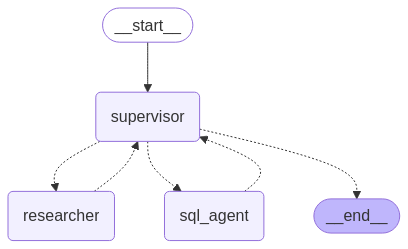

In [12]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

# Ahora sÍ, A DISFRUTAR

In [13]:
if __name__ == '__main__':
    
    sql_result = process_message("Que agente genero mas dinero en el año 2009?")
    print("SQL Query Result:", sql_result)
    
    research_result = process_message("¿Cuál es la capital de Francia?")
    print("\nResearch Result:", research_result)
    
    followup_result = process_message("¿Cuántos habitantes tiene este pais??")
    print("\nFollow-up Result:", followup_result)

C:\Users\Abraham Pérez\AppData\Local\Temp\ipykernel_1956\793116714.py:7: LangChainDeprecationWarning: Please see the migration guide at: https://python.langchain.com/docs/versions/migrating_memory/
  session_memories[session_id] = ConversationBufferMemory(


SQL Query Result: {'response': 'El agente que generó más dinero en el año 2009 fue Steve Johnson, con un total de 164.34.', 'last_agent': 'FINISH', 'session_id': 'default'}

Research Result: {'response': 'La capital de Francia es **París**. Esta ciudad no solo es la más poblada del país, sino que también es un importante centro cultural y comercial a nivel mundial. Para más información, puedes consultar [este artículo de Wikipedia](https://es.wikipedia.org/wiki/Capital_de_Francia).', 'last_agent': 'FINISH', 'session_id': 'default'}

Follow-up Result: {'response': 'Francia tiene una población de aproximadamente **68 millones de habitantes** en 2023. Este dato refleja un aumento del 0.3% respecto al año anterior. Para más detalles, puedes consultar la información en [RFI](https://www.rfi.fr/es/m%C3%A1s-noticias/20230117-la-poblaci%C3%B3n-de-francia-se-sit%C3%BAa-en-68-millones-en-2023) o en [Datosmacro](https://datosmacro.expansion.com/demografia/poblacion/francia).', 'last_agent': 'FINI